In [1]:
%%capture
# to suppress import warnings from h5py

import numpy as np
import numexpr as ne
import h5py,pickle,os
import matplotlib.pyplot as plt
from multislice.prop_utils import number_of_steps

from os.path import dirname as up
#https://stackoverflow.com/a/44732493

Importing all the required libraries.

In [2]:
def make_zp_from_rings(n,grid_size):
    zp = np.zeros((grid_size,grid_size))
    for i in range(n):
        if i%2 == 1 :
            locs_ = np.load('ring_locs_'+str(i)+'.npy')
            locs_ = tuple((locs_[0],locs_[1]))
            vals_ = np.load('ring_vals_'+str(i)+'.npy')
            zp[locs_] = vals_
    return zp

*make_zp_from_rings* : make a zone plate from the rings which were created earlier.
* *Inputs* : n - number of rings, grid_size 
* *Outputs* : a numpy array containing the zone plate

grid_size  :  55296
step_xy  :  4.738222262408356e-09
energy(in eV)  :  10000
wavelength in m  :  1.23984e-10
focal_length  :  0.01
zp_coords  :  [-0.000131, 0.000131, -0.000131, 0.000131]
delta  :  2.9912e-05
beta  :  2.2073e-06


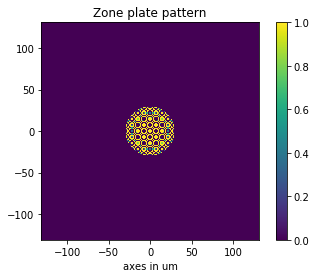

In [3]:
# Change directory to where the zone plate pattern 
# is stored. Load and plot the zone plate pattern.

pwd = os.getcwd()
os.chdir(up(up(os.getcwd()))+str('/zp_database/hard_xray_zp/'))

parameters = pickle.load(open('parameters.pickle','rb'))
for i in parameters : print(i,' : ',parameters[i])

wavel = parameters['wavelength in m']
step_xy = parameters['step_xy']
zp_coords = parameters['zp_coords']
grid_size = parameters['grid_size']

zp = make_zp_from_rings(700,int(grid_size))

plt.imshow(zp,extent=np.array(zp_coords)*1e6)
plt.title('Zone plate pattern')
plt.xlabel('axes in um')
plt.colorbar()
plt.show()

As we see, the actual zone plate pattern just takes up a small part of the total array.
Hence we will "reduce" the total array to a smaller array which will be used to rotate the optic.

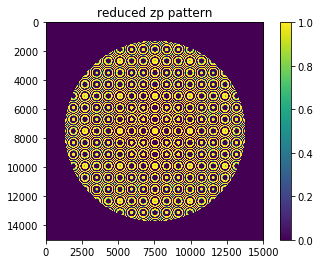

In [4]:
N = int(55296/2)
n = 7500
zp_new = np.copy(zp[N-n:N+n,N-n:N+n])
del zp

plt.imshow(zp_new)
plt.title('reduced zp pattern')
plt.colorbar()
plt.show()

In [5]:
# the thickness is set such that Q=3.3333
# Check for the required step size for multislice
# which is calulated as per the pixel size and 
# propagation distance

zp_thickness = 7.5938e-6  
nsteps =  number_of_steps(step_xy,wavel,zp_thickness)

suggested step size : 1.8107780203882884e-06
number of steps required for propogation through the zone plate : 4


In [6]:
# Store the suggested step size from previous cell output
suggested_step_size = 1.8107780203882884e-06

# larget tilt angle we wish to simulate
angle = 5 

# need these many slices along z for rotation
# 2x number of steps given by the number_of_steps function
# and extra slices to account for the rotation
rot_slices   = 8 + 2*int(np.ceil(((step_xy*7500)*np.sin(np.deg2rad(angle)))/(suggested_step_size)))

# The outermost pixel will get dispalced by this amount 
rot_distance = (step_xy*7500)*np.sin(np.deg2rad(angle)) + zp_thickness/2
print("rotation_distance : ",rot_distance)
print('for '+str(angle)+' degrees, we need :',rot_slices,'slices')
print("rotation_slices : ",rot_slices)

#need to expand to these many slices
expand_slices = suggested_step_size/step_xy
print("expand_slices : ",expand_slices)

rotation_distance :  6.894124604377671e-06
for 5 degrees, we need : 12 slices
rotation_slices :  12
expand_slices :  382.16401006648886


In [7]:
# Set the number of slices to expand along z axis.
# We need to do this because the rotation will
# be performed with an off the shelf image processing
# library that assumes similar pixel sizes in both
# directions.

expand_slices = 200
step_z        = expand_slices*step_xy      # Step size along direction of propagation.
total_z       = step_z*((rot_slices-1)/2)  # Maximum allowable tilt displacement in one direction

print("expand_slices : ",expand_slices)
print("step_z  : ",step_z)
print("total_z : ",total_z)

expand_slices :  200
step_z  :  9.476444524816711e-07
total_z :  5.212044488649191e-06


In [8]:
#Check that the above settings are valid. 

if total_z < rot_distance:
    print("WARN : Not enough space to account for tilt displacement")
if step_z > suggested_step_size:
    print("WARN : Step size too large")

WARN : Not enough space to account for tilt displacement


In [9]:
# Change working directory.
os.chdir(pwd)

# Remove any old copy and create a new file
if os.path.exists('zp_reduced.hdf5'):
    !rm zp_reduced.hdf5

f = h5py.File('zp_reduced.hdf5')

In [10]:
# Create a dataset to hold the reduced zone plate pattern
dset = f.create_dataset("zp_reduced",np.shape(zp_new),chunks=True)

# Transfer the data
dset[:,:] = zp_new

# Store the parameters associated with the zone plate
dset.attrs['suggested_step_size'] = suggested_step_size
dset.attrs['zp_thickness']        = zp_thickness
dset.attrs['step_xy']             = step_xy
dset.attrs['rotation_slices']     = rot_slices
dset.attrs['expand_slices']       = expand_slices
dset.attrs['step_z']              = step_z
dset.attrs['max_angle']           = angle

In [11]:
# Close the file.

f.close()